# Data Wrangling

### Step 1. Load Modules

In [1]:
# Import modules
import pandas as pd
import numpy as np
import datetime
import os as os
import matplotlib.pyplot as plt
import seaborn as sns

# Set so jupyter displays all columns
pd.set_option('display.max_columns', False)

#### Load data

In [2]:
# Change to directory with raw data
os.chdir('../data/raw')

In [3]:
# Load in csv files
sales = pd.read_csv('sales data-set.csv')
features = pd.read_csv('Features data set.csv')
stores = pd.read_csv('stores data-set.csv')

#### Inspect DataFrames to understand structure

In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [5]:
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


In [6]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [7]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [8]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [9]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


#### Convert 'Date' columns to datetime objects

In [10]:
sales['Date'] = pd.to_datetime(sales['Date'])

In [11]:
features['Date'] = pd.to_datetime(features['Date'])

#### Describe features for outliers

In [12]:
sns.set()

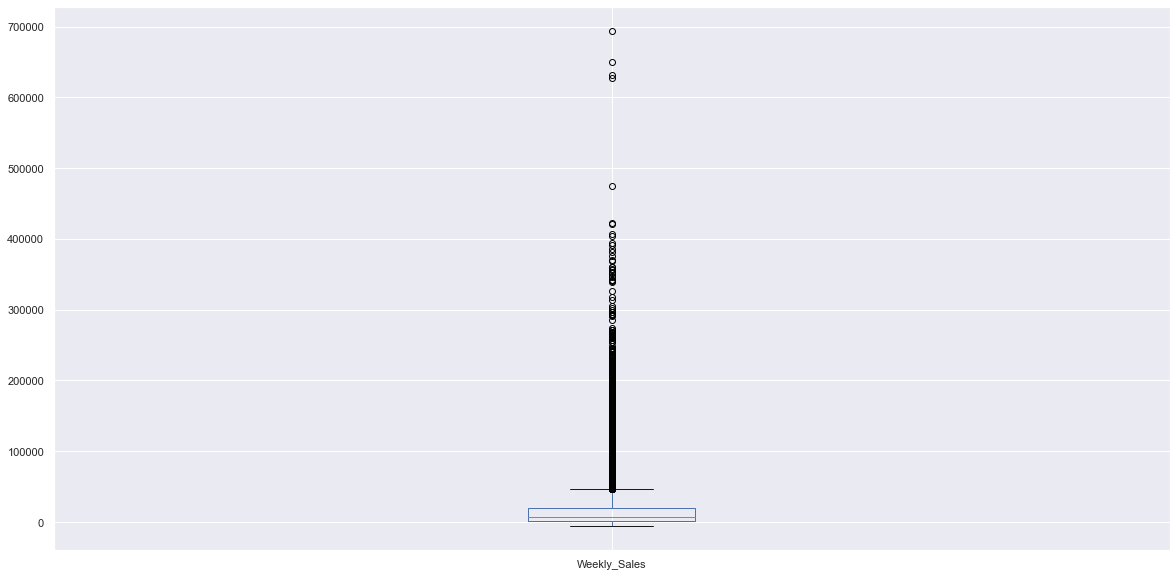

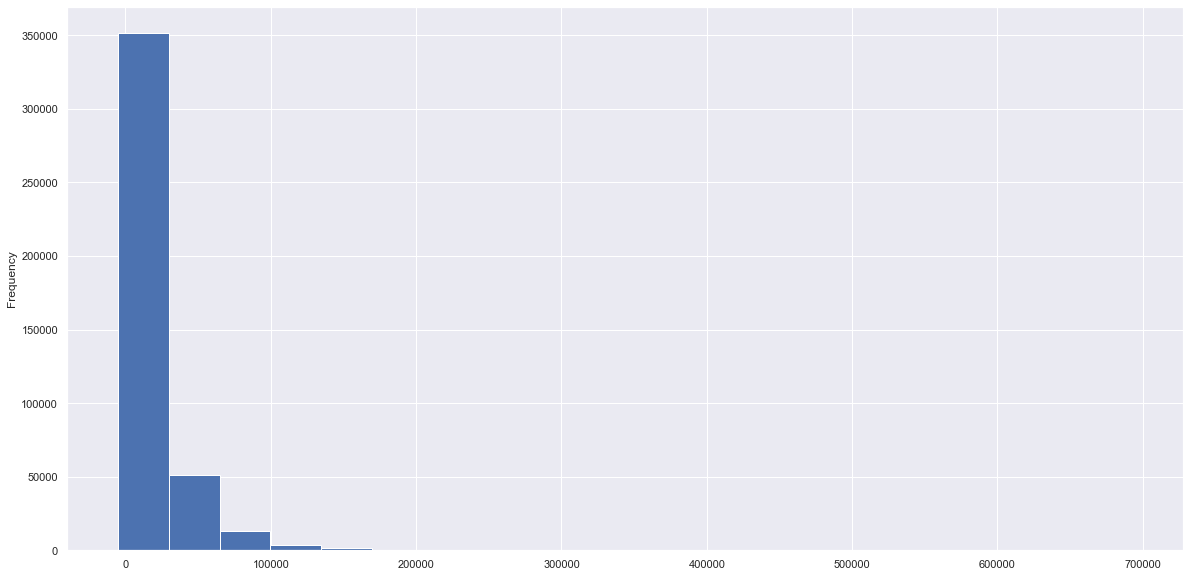

In [22]:
# Create boxplot and histogram of weekly sales to see what distribution looks like
_ = sales['Weekly_Sales'].plot(kind='box', figsize=(20,10))
plt.show()
plt.close()

_ = sales['Weekly_Sales'].plot(kind='hist', bins=20, figsize=(20,10))
plt.show()
plt.close()

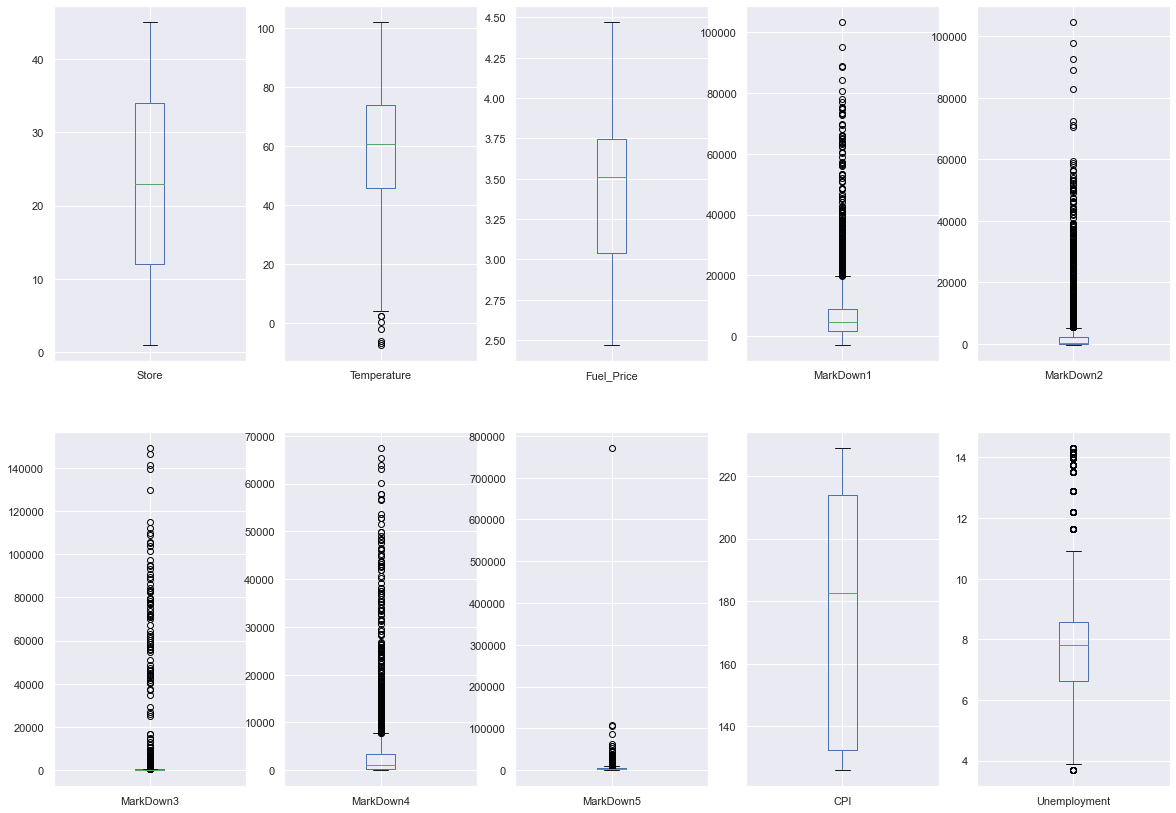

In [13]:
# Create boxplot of features to see if any outliers jump out
_ = features.plot(kind='box', subplots=True, layout=(4,5), figsize=(20,30))
plt.show()
plt.close()

It looks like there's an outlier in MarkDown 5. Comparing it to all other markdowns, a value of ~800,000 seems like an error that should be removed.

In [19]:
# Find row containing MarkDown5 outlier
features.loc[features['MarkDown5']==features['MarkDown5'].max()]

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
5059,28,2012-11-16,49.39,3.834,10431.55,184.51,42.72,1422.57,771448.1,131.3258,10.199,False


In [20]:
# Replace the outlier with the median()
features['MarkDown5'].replace(features['MarkDown5'].max(), features['MarkDown5'].median(), inplace=True)

In [21]:
# Verify that the outlier was removed.
features['MarkDown5'].max()

108519.28

#### Merge data into a single dataframe

In [22]:
# Merging features data onto sales data
df = pd.merge(left=sales, right=features, on=['Date','Store', 'IsHoliday'])

In [23]:
# Merge store data onto the joined df
df = pd.merge(left=df, right=stores, on='Store')

In [24]:
# Verify that the correct number of observations are there
df.shape

# 421570 rows from the sales data, so this looks good

(421570, 16)

In [25]:
# Sort data by Date and Store
df = df.sort_values(by=['Date', 'Store'])

In [26]:
# Reset index
df = df.reset_index(drop=True)

#### Split data into two sets - one before markdowns were tracked, and one after

Markdown data was not recorded until after November 2011. All null values prior to 2011 are truly unknown, and should not be dropped or converted to a mean/median. Rather than treat before/after markdown recording data the same way, I think it would be best to split them into two separate dataframes

In [27]:
# Split data into df1 (before markdown recording) and df2 (after markdown recording)
df1 = df.loc[df['Date'] < '2011-11-03']
df2 = df.loc[df['Date'] >= '2011-11-03']

#### Change null values in df2 to 0, indicating there were no markdowns on those days

Unsure of the best way to deal with null values in df1 at this point, but will drop null values in df2 to 0 for markdowns

In [28]:
# Check to see if there are null values in any columns other than markdowns
df2.isnull().any()

Store           False
Dept            False
Date            False
Weekly_Sales    False
IsHoliday       False
Temperature     False
Fuel_Price      False
MarkDown1        True
MarkDown2        True
MarkDown3        True
MarkDown4        True
MarkDown5        True
CPI             False
Unemployment    False
Type            False
Size            False
dtype: bool

In [29]:
# There are no other columns with null values, so we can apply null transformation on entire dataframe rather than subset
df2 = df2.fillna(0)

#### Export df1 and df2 to csv files for later use

In [30]:
# Change directory to interim data folder
os.chdir('../interim')

In [31]:
df1.to_csv('joined data pre-markdowns.csv', index=False)

In [32]:
df2.to_csv('joined data post-markdowns.csv', index=False)